In [1]:
import sys
sys.path.append('../src')
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.io import loadmat, wavfile
from scipy.interpolate import RegularGridInterpolator
import re, glob
from utils import *

In [2]:
act_func = lambda x: torch.log(1+x**2)
# act_func = lambda x: torch.tanh(x)
class audioNet(nn.Module):
    def __init__(self, output_dim, kernel_dims, pad, stride):
        super(audioNet, self).__init__()
        self.w1 = nn.Conv2d(in_channels=1, out_channels=output_dim, 
                            kernel_size=kernel_dims, padding=pad, 
                            stride=stride, bias=False)
        
    def forward(self, x):
        x = torch.unsqueeze(x, dim=1) # first dim is batch
        y = act_func(self.w1(x))
        return y

In [3]:
note_files = glob.glob('/home/zg93/Downloads/B447/*.not.mat')
audios = []
for f in note_files:
    notes = loadmat(f)
    start_idx = np.array([m.start() for m in re.finditer('iabcdef', str(notes['labels'][0]))])
    if len(start_idx) == 0:
        continue
    fs, audio = wavfile.read(f.replace('.not.mat', ''))
    song_on = notes['onsets'][start_idx,0]
    song_off = notes['onsets'][start_idx+6,0] # offset of syl f
    song_on = (song_on / 1000 * fs).astype(int) # originally in ms
    song_off = (song_off / 1000 * fs).astype(int) # originally in ms
    for t0, t1 in zip(song_on, song_off):
        audios.append(audio[t0:t1])
        
audio_Ts = np.array(list(map(len, audios))) / fs * 1000 # raw time in ms

In [4]:
def get_spec(audio, fs, min_freq, max_freq, num_freq_bins, num_time_bins, 
             spec_min, spec_max, nperseg=256, noverlap=128):
    T = len(audio) / fs # end time
    audio = audio - np.mean(audio) # remove dc component
    f, t, spec = stft(audio, fs=fs, nperseg=nperseg, noverlap=noverlap)
    spec = np.log(np.abs(spec) + 1e-12)

    # interpolation
    interp = RegularGridInterpolator((f, t), spec, bounds_error=False, fill_value=-1e12)
    target_freqs = np.linspace(min_freq, max_freq, num_freq_bins)
    target_times = np.linspace(0, T, num_time_bins)
    tnew, fnew = np.meshgrid(target_times, target_freqs, indexing='xy', sparse=True)
    spec = interp((fnew, tnew))
    
    # normalize
    spec = (spec - spec_min) / (spec_max - spec_min)
    spec = np.clip(spec, 0.0, 1.0)
    return spec

In [5]:
# generate spectrograms for both ctrl and pert cases
rng = np.random.default_rng()
audio_pert = []
specs = []
specs_pert = []

kwargs = dict(min_freq=5e2, max_freq=10e3, num_freq_bins=50, 
              num_time_bins=140, spec_min=4, spec_max=6.5)
for audio, T in zip(audios, audio_Ts):
    specs.append(get_spec(audio, fs, **kwargs))
    
    _ = audio.copy()
    ts = np.linspace(0, T, endpoint=False, num=len(_))
    mask = (ts > 400) & (ts < 450)
    _[mask] = rng.normal(0, 5e4, size=mask.sum())
    audio_pert.append(_)
    specs_pert.append(get_spec(_, fs, **kwargs))
specs = np.stack(specs, axis=0) # (num_samples, num_freq_bins, num_time_bins)
specs_pert = np.stack(specs_pert, axis=0)

[[<matplotlib.axis.YTick at 0x7a1a04f61c30>,
 Text(0.5, 1.0, 'Perturbed'),
 Text(0.5, 0, 'time (ms)')]

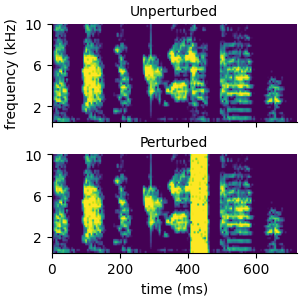

In [6]:
fig, ax = plt.subplots(2, sharex='all', figsize=(3, 3))
i = 1
ax[0].imshow(specs[0], cmap='viridis', origin='lower', 
             extent=(0, audio_Ts[i], 0.5, 10))
ax[1].imshow(specs_pert[0], cmap='viridis', origin='lower', 
             extent=(0, audio_Ts[i], 0.5, 10))
ax[0].set(yticks=[2, 6, 10], ylabel='frequency (kHz)', title='Unperturbed')
ax[1].set(yticks=[2, 6, 10], title='Perturbed', xlabel='time (ms)')

In [7]:
net = audioNet(100, (25,16), pad=(0,0), stride=(5,1))
net.load_state_dict(torch.load('net_params.pkl'))

<All keys matched successfully>

In [8]:
# x_ctrl = torch.tensor(specs - specs.mean(axis=(1,2),keepdims=True), 
#                       dtype=torch.float32)
# x_pert = torch.tensor(specs_pert - specs_pert.mean(axis=(1,2),keepdims=True), 
#                       dtype=torch.float32)
x_ctrl = torch.tensor(specs, dtype=torch.float32)
x_pert = torch.tensor(specs_pert, dtype=torch.float32)
y_ctrl = net(x_ctrl).detach().numpy()
y_pert = net(x_pert).detach().numpy()
print(y_ctrl.shape)
# (sample, N_neurons, T)
y_ctrl = np.stack([np.vstack(y_ctrl[i]) for i in range(y_ctrl.shape[0])], axis=0) 
y_pert = np.stack([np.vstack(y_pert[i]) for i in range(y_pert.shape[0])], axis=0) 
print(y_ctrl.shape)

(66, 100, 6, 125)
(66, 600, 125)


In [9]:
time_scale_factor = x_ctrl.shape[2] / y_ctrl.shape[2] # due to conv over time

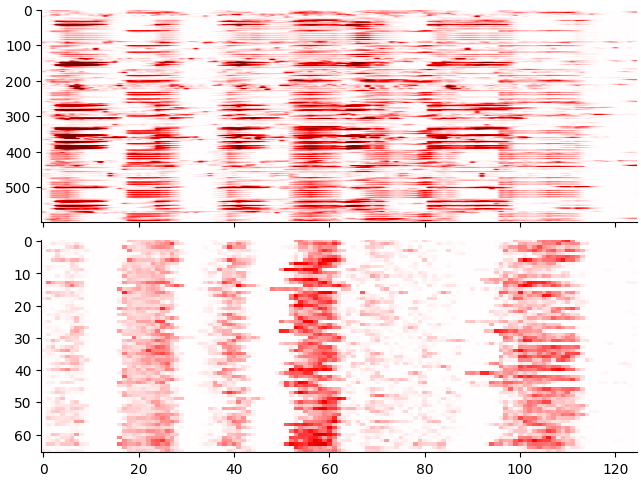

In [10]:
fig, ax = plt.subplots(2, sharex='all')
im = ax[0].imshow(y_ctrl[0], vmin=-0.1, vmax=0.1, aspect='auto', cmap='seismic')
im = ax[1].imshow(y_ctrl[:,10], vmin=-0.3, vmax=0.3, aspect='auto', cmap='seismic')

[[<matplotlib.axis.XTick at 0x7a19f86f1510>,

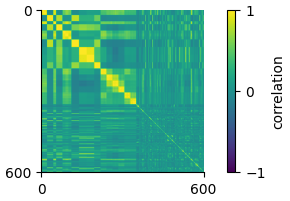

In [11]:
from sklearn.cluster import HDBSCAN
fig, ax = plt.subplots(1, figsize=(3, 2))
corr = np.mean([correlation(i, i, dim=2) for i in y_ctrl], axis=0)
corr = np.maximum(corr, corr.T)
hdb = HDBSCAN(metric='precomputed', min_cluster_size=10)
hdb.fit(1-corr)
idx = np.argsort(hdb.labels_)[::-1] # [::-1] puts -1 in the end
im = ax.imshow(corr[idx,:][:,idx], vmin=-1, vmax=1, aspect=1)
fig.colorbar(im, ax=ax, label='correlation', ticks=[-1, 0, 1])
ax.set(xticks=[0, 600], yticks=[0, 600])

In [12]:
audio_T_max = 800 # ms
Ts = (audio_Ts / audio_Ts.max()) * audio_T_max # scale a little bit
target_ts = np.arange(int(round(audio_T_max * time_scale_factor))) 
song_responses = dict(ctrl=np.zeros((y_ctrl.shape[0], y_ctrl.shape[1], len(target_ts))), 
                      pert=np.zeros((y_pert.shape[0], y_pert.shape[1], len(target_ts))))
for i in range(y_ctrl.shape[0]):
    ts = np.linspace(0, Ts[i] * time_scale_factor, endpoint=False, num=y_ctrl.shape[2])
    for j in range(y_ctrl.shape[1]):
        song_responses['ctrl'][i,j] = np.interp(target_ts, ts, y_ctrl[i,j], left=0, right=0)
        song_responses['pert'][i,j] = np.interp(target_ts, ts, y_pert[i,j], left=0, right=0)

/tmp/ipykernel_218131/1923185398.py:2: RuntimeWarning: divide by zero encountered in divide
  diff = ((song_responses['pert'] - song_responses['ctrl']) \
/tmp/ipykernel_218131/1923185398.py:2: RuntimeWarning: invalid value encountered in divide
  diff = ((song_responses['pert'] - song_responses['ctrl']) \


[Text(0, 0.5, 'neuron index'),
 Text(0.5, 0, 'time (ms)'),
 [],
 Text(0.5, 1.0, 'Change in activity\ndue to perturbation')]

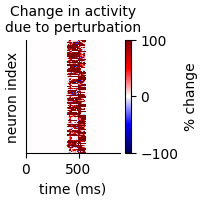

In [13]:
fig, ax = plt.subplots(1, figsize=(2,2))
diff = ((song_responses['pert'] - song_responses['ctrl']) \
        / song_responses['ctrl']).mean(axis=0) * 100
im = ax.imshow(diff, aspect='auto', 
               extent=(0, 800*time_scale_factor, 1, y_ctrl.shape[1]+1), 
               interpolation='none', vmin=-100, vmax=100, cmap='seismic')
fig.colorbar(im, ax=ax, label='% change', ticks=[-100, 0, 100])
ax.set(ylabel='neuron index', xlabel='time (ms)', yticks=[], 
       title='Change in activity\ndue to perturbation')

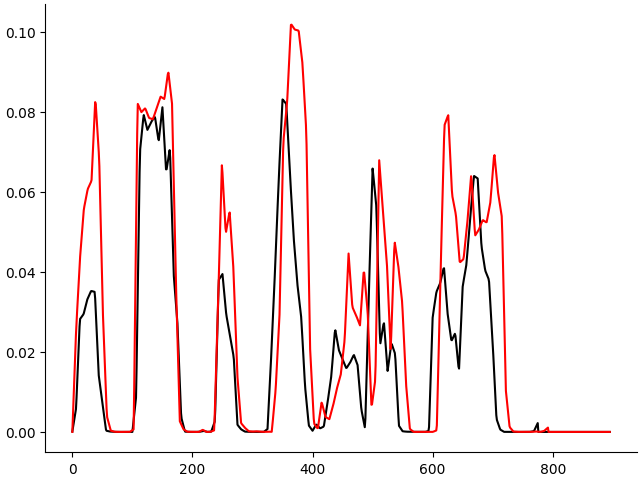

In [14]:
plt.plot(song_responses['ctrl'][0,0], c='k')
plt.plot(song_responses['ctrl'][2,0], c='r')
# plt.plot(song_responses['pert'][0,0], c='b')

Text(0, 0.5, 'Mean responses (original scale)')

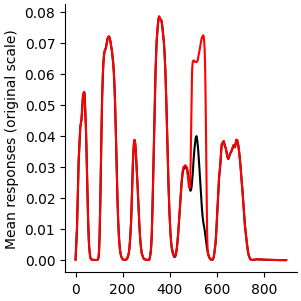

In [19]:
fig, ax = plt.subplots(1, figsize=(3, 3))
ax.plot(song_responses['ctrl'][:,1].mean(axis=0), c='k')
ax.plot(song_responses['pert'][:,1].mean(axis=0), c='r')
ax.set_ylabel('Mean responses (original scale)')

/home/zg93/Projects/Aiv-Network/learn_realistic_auditory_processing/../src/utils.py:56: RuntimeWarning: invalid value encountered in divide
  return (sig - m) / s


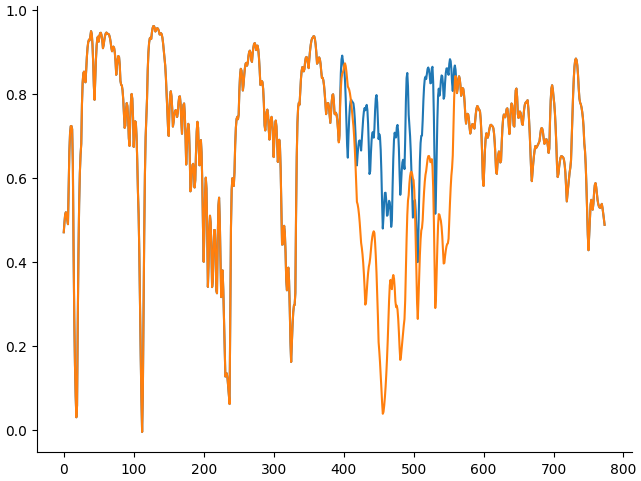

In [16]:
plt.plot(correlation(song_responses['ctrl'][0].T, song_responses['ctrl'][4].T, dim=1))
plt.plot(correlation(song_responses['ctrl'][0].T, song_responses['pert'][4].T, dim=1))

In [17]:
song_responses['specs_ctrl'] = specs
song_responses['specs_pert'] = specs_pert
np.savez('learned_song_responses.npz', **song_responses)